In [3]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Reading the data from input csv file into a Pandas DataFrame
emp_attr_data = pd.read_csv("HR_comma_sep.csv")
emp_attr_data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [4]:
# EDA 
print("Shape:", emp_attr_data.shape)
print("Columns:", emp_attr_data.columns.tolist())
print("\nMissing values:\n", emp_attr_data.isnull().sum())
print("\nTarget distribution:\n", emp_attr_data['left'].value_counts(normalize=True))

Shape: (14999, 10)
Columns: ['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company', 'Work_accident', 'left', 'promotion_last_5years', 'Department', 'salary']

Missing values:
 satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
Department               0
salary                   0
dtype: int64

Target distribution:
 left
0    0.761917
1    0.238083
Name: proportion, dtype: float64


In [5]:
# PREPARE DATA 
# Feature engineering: salary mapping & Department one-hot
salary_map = {"low": 0, "medium": 1, "high": 2}
emp_attr_data['salary_level'] = emp_attr_data['salary'].map(salary_map)

# One-hot encode Department
dept_dummies = pd.get_dummies(emp_attr_data['Department'], prefix='dept')
# Drop original categorical columns
emp_attr_data_clean = emp_attr_data.drop(columns=['Department', 'salary'])
# Combine into final dataset
emp_attr_data_model = pd.concat([emp_attr_data_clean, dept_dummies], axis=1)
print("Cleaned dataset shape:", emp_attr_data_model.shape)

# Prepare features (X) and target (y)
avg_hours_col = 'average_montly_hours' # we know this is the correct column
X = emp_attr_data_model.drop(columns=['left'])
y = emp_attr_data_model['left']
print("X shape:", X.shape)
print("y shape:", y.shape)

Cleaned dataset shape: (14999, 19)
X shape: (14999, 18)
y shape: (14999,)


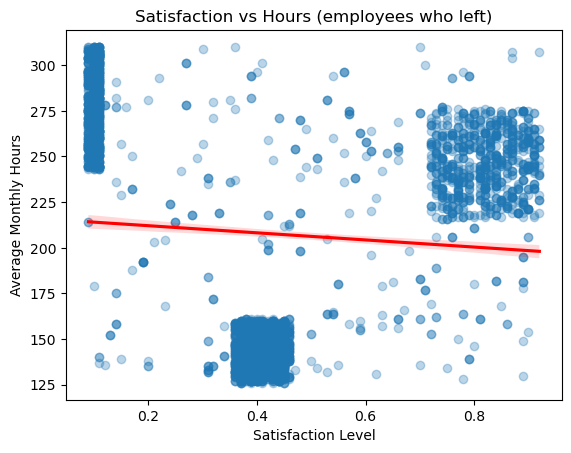

Correlation: -0.0841


In [6]:
# Relationship: satisfaction vs monthly hours (for employees who left) import seaborn as sns

left_emp_attr_data = emp_attr_data[emp_attr_data['left'] == 1]
satisfaction_hours = left_emp_attr_data[['satisfaction_level', 'average_montly_hours']]

# Scatter + regression line with Seaborn
sns.regplot(
    data=left_emp_attr_data,
    x='satisfaction_level',
    y=avg_hours_col,
    scatter_kws={'alpha':0.3},   # transparency for scatter points
    line_kws={'color':'red'}     # color for regression line
)

plt.xlabel("Satisfaction Level")
plt.ylabel("Average Monthly Hours")
plt.title("Satisfaction vs Hours (employees who left)")
plt.show()

# Correlation
corr = np.corrcoef(left_emp_attr_data['satisfaction_level'], left_emp_attr_data[avg_hours_col])[0,1]
print(f"Correlation: {corr:.4f}")



Left rate by salary:
    salary      left
0    high  0.066289
1     low  0.296884
2  medium  0.204313


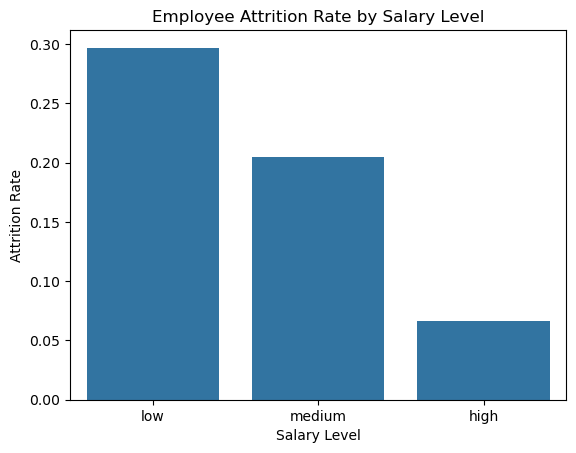


Left rate by promotion:
    promotion_last_5years      left
0                      0  0.241962
1                      1  0.059561


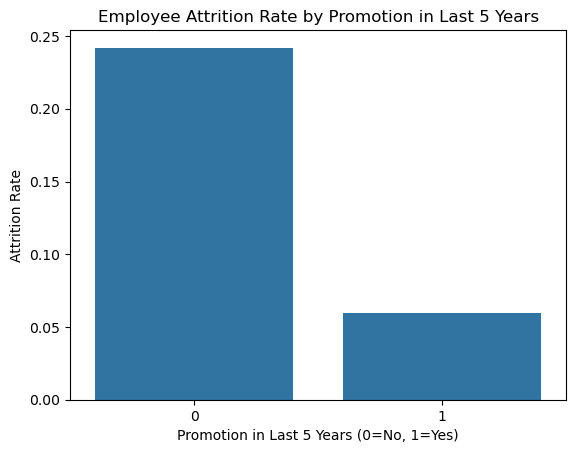


Left rate by department:
     Department      left
0           IT  0.222494
1        RandD  0.153748
2   accounting  0.265971
3           hr  0.290934
4   management  0.144444
5    marketing  0.236597
6  product_mng  0.219512
7        sales  0.244928
8      support  0.248991
9    technical  0.256250


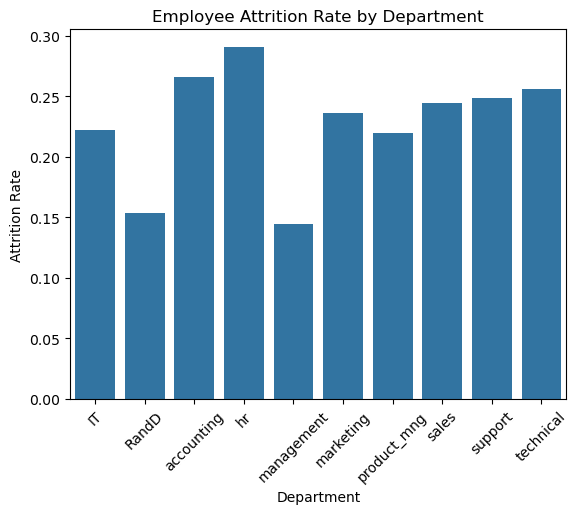

In [7]:
# Grouped Analysis with Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Left rate by salary
salary_left = emp_attr_data.groupby('salary')['left'].mean().reset_index()
print("\nLeft rate by salary:\n", salary_left)

sns.barplot(data=salary_left, x='salary', y='left', order=['low','medium','high'])
plt.title("Employee Attrition Rate by Salary Level")
plt.ylabel("Attrition Rate")
plt.xlabel("Salary Level")
plt.show()

# Left rate by promotion
promo_left = emp_attr_data.groupby('promotion_last_5years')['left'].mean().reset_index()
print("\nLeft rate by promotion:\n", promo_left)

sns.barplot(data=promo_left, x='promotion_last_5years', y='left')
plt.title("Employee Attrition Rate by Promotion in Last 5 Years")
plt.ylabel("Attrition Rate")
plt.xlabel("Promotion in Last 5 Years (0=No, 1=Yes)")
plt.show()

# Left rate by department
dept_left = emp_attr_data.groupby('Department')['left'].mean().reset_index()
print("\nLeft rate by department:\n", dept_left)

sns.barplot(data=dept_left, x='Department', y='left')
plt.title("Employee Attrition Rate by Department")
plt.ylabel("Attrition Rate")
plt.xlabel("Department")
plt.xticks(rotation=45)
plt.show()


In [8]:
# Train/test split + scaling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

numeric_cols = ['satisfaction_level','last_evaluation','number_project',
                avg_hours_col,'time_spend_company']

scaler = StandardScaler()
X_train_scaled, X_test_scaled = X_train.copy(), X_test.copy()
X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [9]:
# Train models + Evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, roc_curve
)

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}
trained = {}; metrics = {}
for name, model in models.items():
    if name == "LogisticRegression":
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)
        probs = model.predict_proba(X_test_scaled)[:,1]
    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        probs = model.predict_proba(X_test)[:,1]
        
    metrics[name] = {
        "accuracy": accuracy_score(y_test, preds),
        "precision": precision_score(y_test, preds),
        "recall": recall_score(y_test, preds),
        "f1": f1_score(y_test, preds),
        "roc_auc": roc_auc_score(y_test, probs)
    }
    trained[name] = model
    
metrics_emp_attr_data = pd.DataFrame(metrics).T
metrics_emp_attr_data

,accuracy,precision,recall,f1,roc_auc
LogisticRegression,0.797667,0.627078,0.369748,0.465198,0.825302
RandomForest,0.990333,0.995658,0.963585,0.979359,0.991319
GradientBoosting,0.974667,0.958333,0.934174,0.946099,0.990434


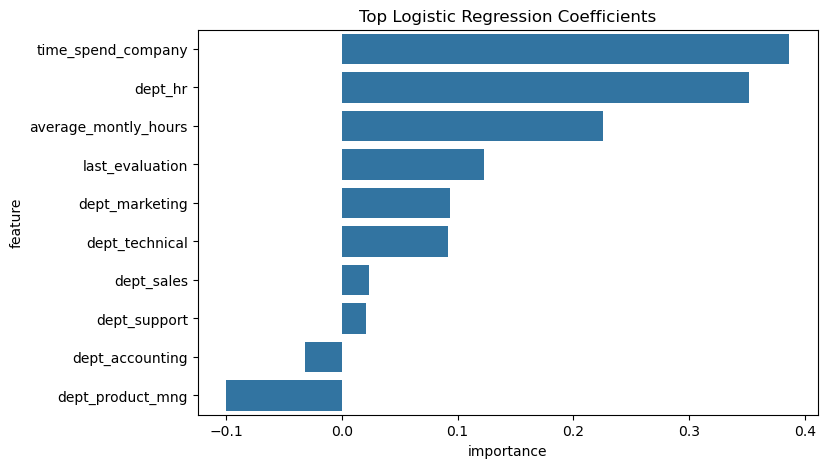

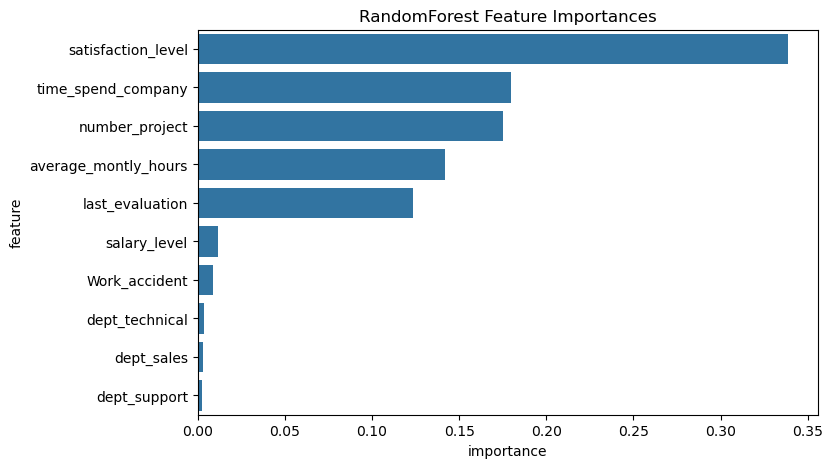

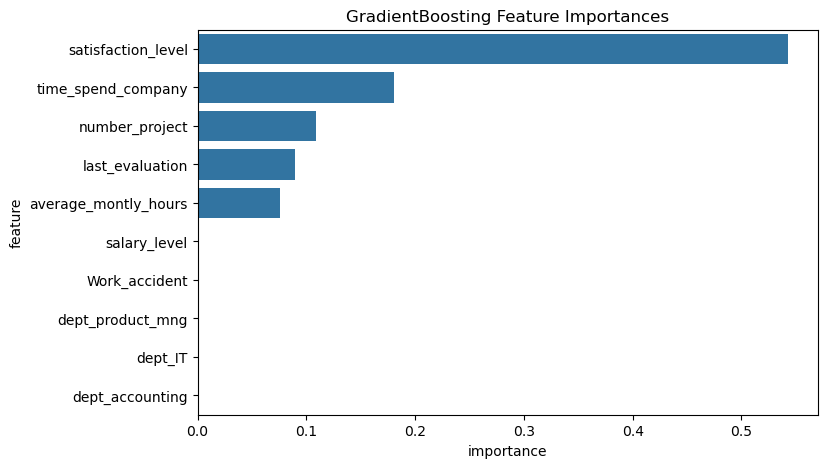

In [10]:
# Feature Importance & Coefficients
def plot_importance(emp_attr_data_imp, title, feature_col="feature", value_col="importance"):
    emp_attr_data_imp = emp_attr_data_imp.sort_values(value_col, ascending=False)
    plt.figure(figsize=(8,5))
    sns.barplot(x=value_col, y=feature_col, data=emp_attr_data_imp.head(10))
    plt.title(title)
    plt.show()


# Logistic Regression Coefficients
lr = trained["LogisticRegression"]
coef_emp_attr_data = pd.DataFrame({"feature": X_train_scaled.columns, "importance": lr.coef_[0]})
plot_importance(coef_emp_attr_data, "Top Logistic Regression Coefficients", value_col="importance")


# RandomForest Importance
rf = trained["RandomForest"]
rf_imp = pd.DataFrame({"feature": X_train.columns, "importance": rf.feature_importances_})
plot_importance(rf_imp, "RandomForest Feature Importances")


# GradientBoosting Importance
gb = trained["GradientBoosting"]
gb_imp = pd.DataFrame({"feature": X_train.columns, "importance": gb.feature_importances_})
plot_importance(gb_imp, "GradientBoosting Feature Importances")


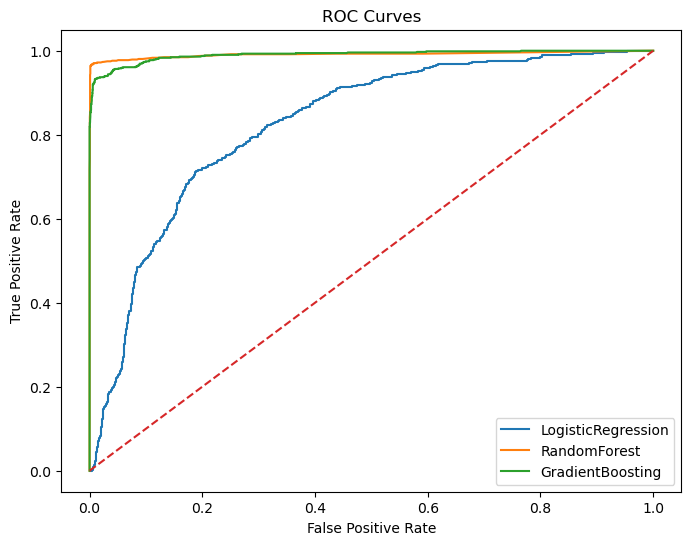

In [11]:
# ROC Curves
from sklearn.metrics import roc_curve
plt.figure(figsize=(8,6))
for name, model in models.items():
    if name == "LogisticRegression":
        probs = model.predict_proba(X_test_scaled)[:,1]
    else:
        probs = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=name)

plt.plot([0,1],[0,1],linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

In [12]:
# Save best model & scaler
best_model_name = metrics_emp_attr_data['roc_auc'].idxmax()
best_model = trained[best_model_name]
best_model

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [17]:
# Export Data for Power BI / Tableau
from openpyxl import Workbook

# Overview sheet
overview = pd.DataFrame({
    "Total_Employees": [len(emp_attr_data)],
    "Employees_Left": [emp_attr_data['left'].sum()],
    "Retention_Rate(%)": [100 * (1 - emp_attr_data['left'].mean())],
    "Attrition_Rate(%)": [100 * emp_attr_data['left'].mean()]
})

# Save to Excel (all sheets)
with pd.ExcelWriter("Employee_Attrition_Insights.xlsx", engine="openpyxl") as writer:
    overview.to_excel(writer, sheet_name="Overview", index=False)
    dept_left.to_excel(writer, sheet_name="By_Department", index=False)
    salary_left.to_excel(writer, sheet_name="By_Salary", index=False)
    promo_left.to_excel(writer, sheet_name="By_Promotion", index=False)
    satisfaction_hours.to_excel(writer, sheet_name="Satisfaction_vs_Hours", index=False)
# Full dataset (cleaned)
    emp_attr_data.to_excel(writer, sheet_name="Full_Data", index=False)

print("Employee_Attrition_Insights.xlsx created successfully!")


Employee_Attrition_Insights.xlsx created successfully!
